In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('player_stats_with_positions.csv',quotechar='"', thousands=',',encoding='utf-8')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19125 entries, 0 to 19124
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_name  19125 non-null  object 
 1   position     19125 non-null  object 
 2   age          18841 non-null  float64
 3   season       18849 non-null  object 
 4   team         18849 non-null  object 
 5   mp           18178 non-null  float64
 6   minutes      18178 non-null  float64
 7   goals        18849 non-null  float64
 8   assists      18849 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.3+ MB


In [4]:
df.describe()

,age,mp,minutes,goals,assists
count,18841.000000,18178.000000,18178.000000,18849.000000,18849.000000
mean,22.418555,22.803389,1565.594455,2.770014,1.795639
std,3.968328,13.690813,1123.104598,4.556463,2.622920
min,12.000000,1.000000,1.000000,0.000000,0.000000
25%,19.000000,11.000000,532.000000,0.000000,0.000000
50%,22.000000,24.000000,1479.000000,1.000000,1.000000
75%,25.000000,34.000000,2462.000000,3.000000,3.000000
max,40.000000,59.000000,5156.000000,55.000000,28.000000


In [5]:
df.shape

(19125, 9)

In [6]:
df.isnull().sum()

player_name      0
position         0
age            284
season         276
team           276
mp             947
minutes        947
goals          276
assists        276
dtype: int64

In [7]:
# 1. Handle Age missing values
# Calculate age for players with multiple entries
df['age'] = df.groupby('player_name')['age'].transform(lambda x: x.ffill().bfill())

# For remaining missing values, use the median age by position
position_median_age = df.groupby('position')['age'].median()
df['age'] = df['age'].fillna(df['position'].map(position_median_age))

# 2. Handle Season/Team missing values - drop these rows as they're fundamental identifiers
df = df.dropna(subset=['season', 'team'])

# 3. Handle MP and Minutes
# Calculate MP from minutes where possible
df['mp'] = np.where(
    df['mp'].isna() & df['minutes'].notna(),
    round(df['minutes']/90),
    df['mp']
)

# For remaining, use median by position and age group
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 25, 30, 40], labels=['<20', '20-25', '25-30', '30+'])

position_age_mp = df.groupby(['position', 'age_group'])['mp'].median().reset_index()
df = df.merge(position_age_mp, on=['position', 'age_group'], how='left', suffixes=('', '_median'))
df['mp'] = df['mp'].fillna(df['mp_median'])

# Similar approach for minutes
position_age_minutes = df.groupby(['position', 'age_group'])['minutes'].median().reset_index()
df = df.merge(position_age_minutes, on=['position', 'age_group'], how='left', suffixes=('', '_median'))
df['minutes'] = df['minutes'].fillna(df['minutes_median'])

# 4. Handle Goals and Assists
# Use median by position
position_median_goals = df.groupby('position')['goals'].median()
df['goals'] = df['goals'].fillna(df['position'].map(position_median_goals))

position_median_assists = df.groupby('position')['assists'].median()
df['assists'] = df['assists'].fillna(df['position'].map(position_median_assists))

# Clean up temporary columns
df = df.drop(columns=['age_group', 'mp_median', 'minutes_median'])

C:\Users\sadok\AppData\Local\Temp\ipykernel_13236\1440452126.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_age_mp = df.groupby(['position', 'age_group'])['mp'].median().reset_index()
C:\Users\sadok\AppData\Local\Temp\ipykernel_13236\1440452126.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_age_minutes = df.groupby(['position', 'age_group'])['minutes'].median().reset_index()


In [8]:
df.isnull().sum()

player_name    0
position       0
age            0
season         0
team           0
mp             0
minutes        0
goals          0
assists        0
dtype: int64

In [9]:
# Drop fully identical rows
df.drop_duplicates(inplace=True)

# Group by player/season/team, handle age and position smartly
def most_frequent_position(x):
    return x.mode().iloc[0] if not x.mode().empty else x.iloc[0]

df = df.groupby(['player_name', 'season', 'team'], as_index=False).agg({
    'position': most_frequent_position,
    'age': 'median',
    'mp': 'sum',
    'minutes': 'sum',
    'goals': 'sum',
    'assists': 'sum'
})

# Check again
remaining_dupes = df.duplicated(subset=['player_name', 'season', 'team']).sum()
print("Remaining duplicates by player/season/team after final aggregation:", remaining_dupes)

# Optional — preview any leftover issues
if remaining_dupes > 0:
    dupes = df[df.duplicated(subset=['player_name', 'season', 'team'], keep=False)]
    print(dupes.sort_values(by=['player_name', 'season', 'team']))


Remaining duplicates by player/season/team after final aggregation: 0


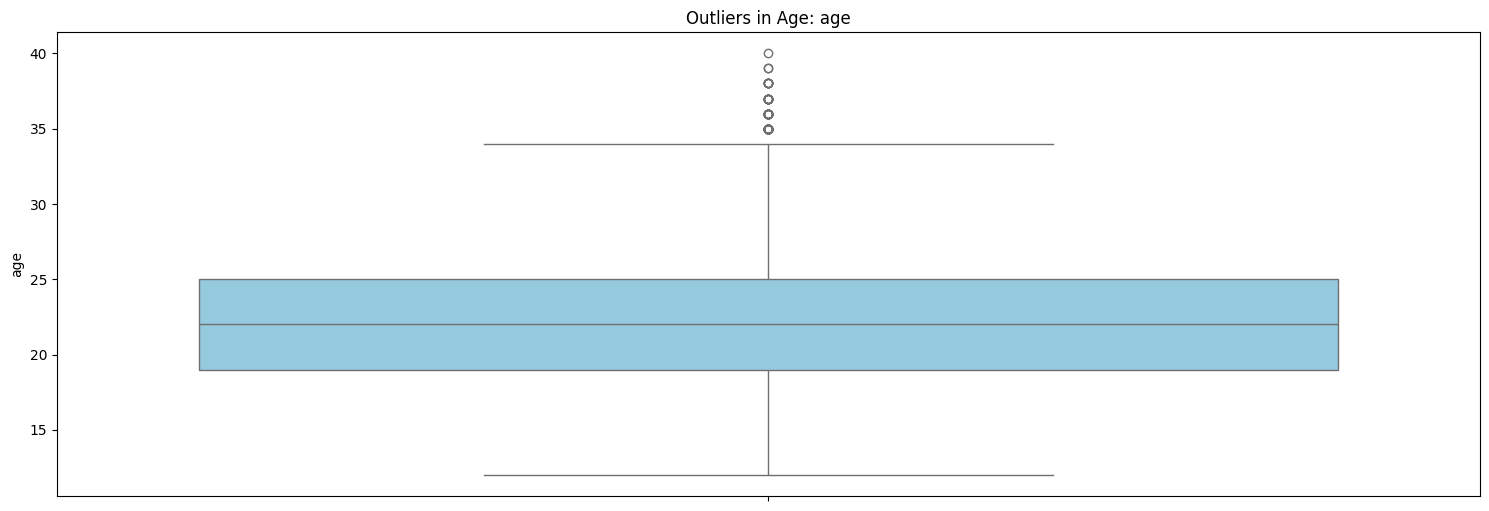

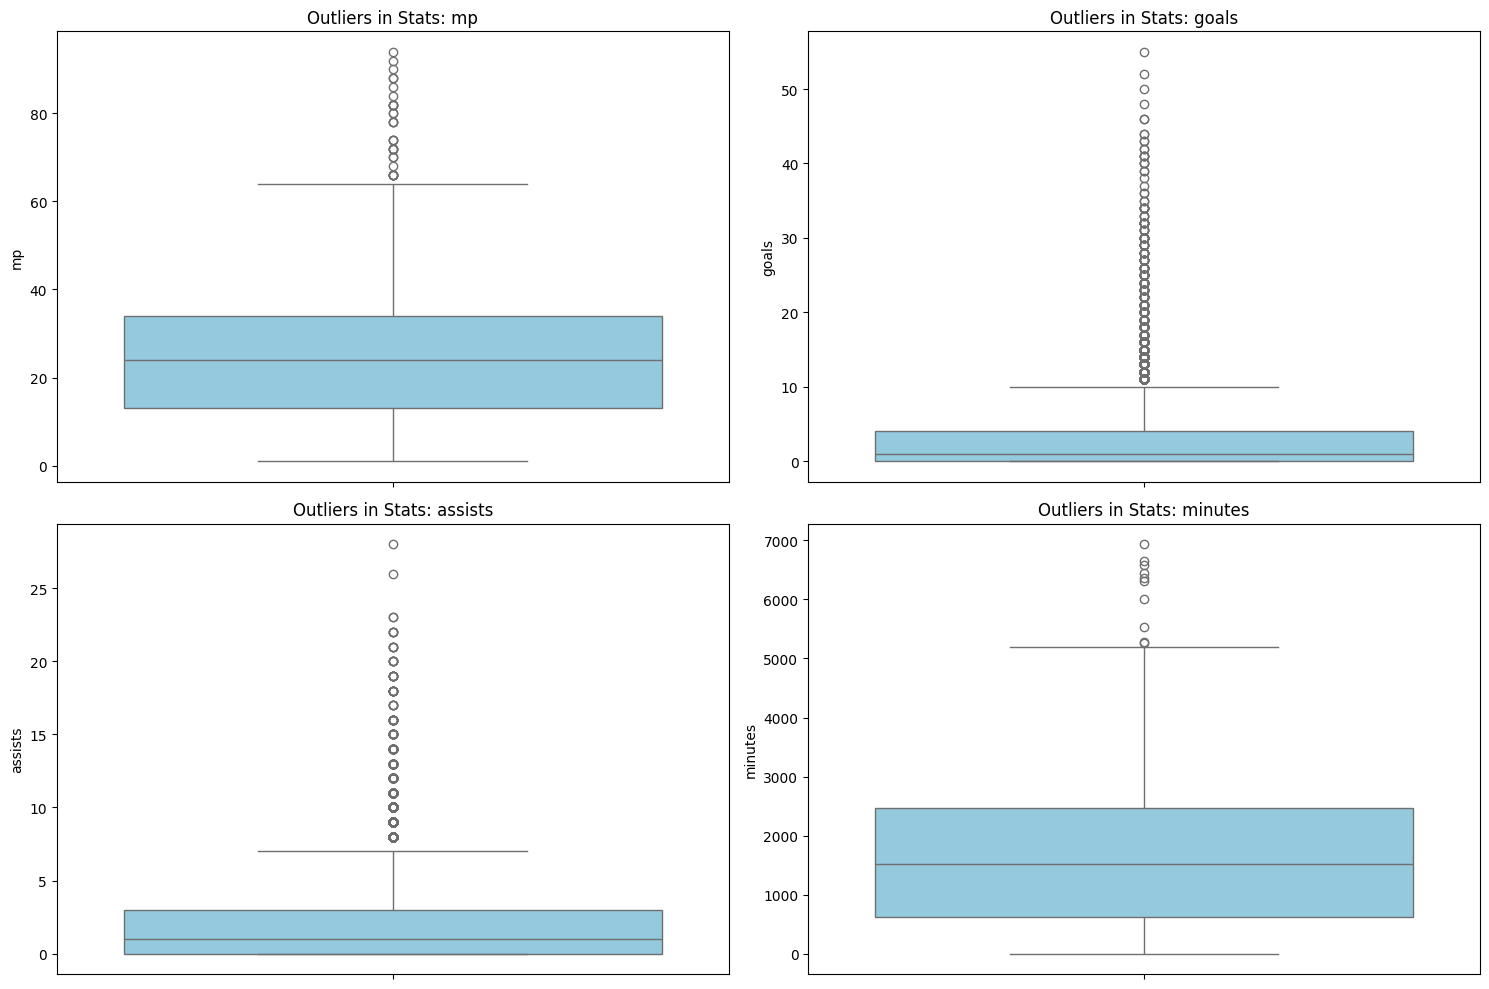

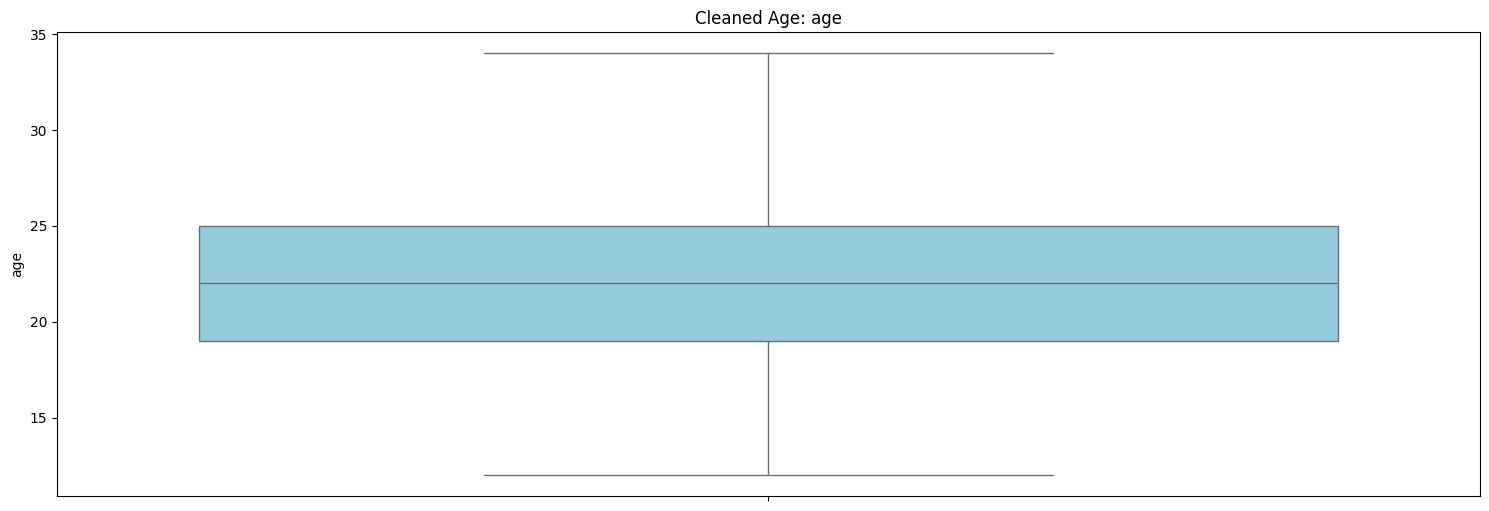

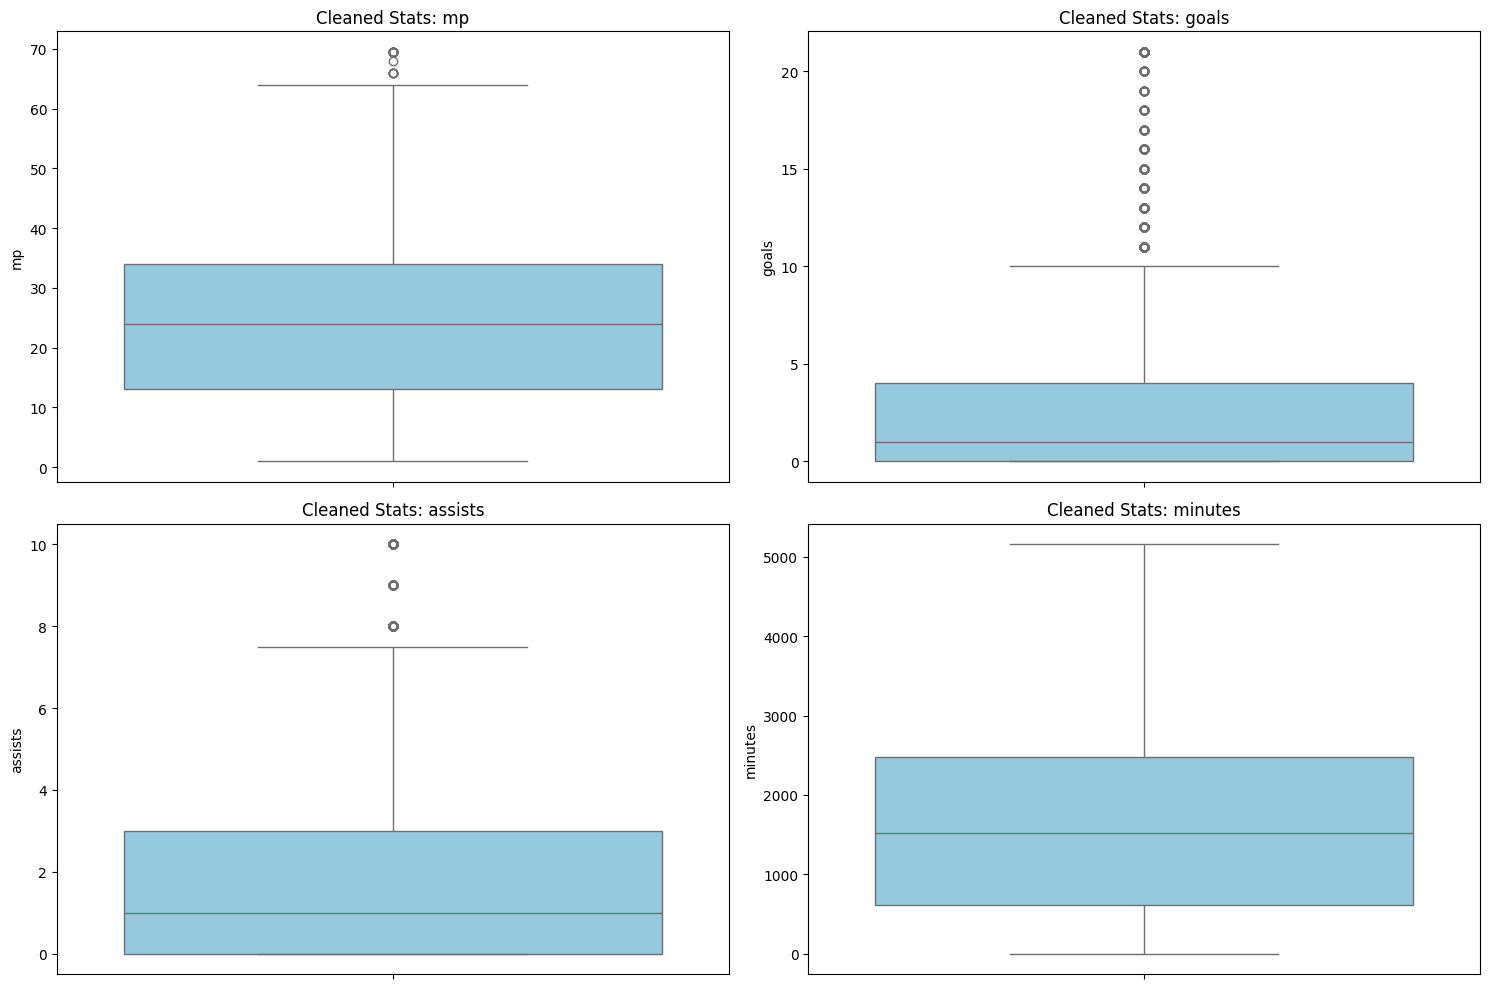

In [10]:
# Function to plot outliers
def plot_outliers(df, columns, title):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns, 1):
        plt.subplot(2, (len(columns) + 1) // 2, i)
        sns.boxplot(y=df[col], color='skyblue')
        plt.title(f'{title}: {col}')
    plt.tight_layout()
    plt.show()

# Function to handle outliers using the IQR method
def handle_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)
    return df_clean

# Function to handle stats outliers by position
def handle_outliers_by_position(df, stats_cols):
    df_clean = df.copy()
    for col in stats_cols:
        df_clean[col] = df_clean.groupby('position')[col].transform(
            lambda x: np.clip(
                x,
                x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)),
                x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))
            )
        )
    return df_clean

# Define numeric columns
age_col = ['age']
stats_cols = ['mp', 'goals', 'assists', 'minutes']

# Step 1: Plot original outliers
plot_outliers(df, age_col, title="Outliers in Age")
plot_outliers(df, stats_cols, title="Outliers in Stats")

# Step 2: Handle age outliers
df = handle_outliers_iqr(df, age_col)

# Step 3: Handle stats outliers by position
df = handle_outliers_by_position(df, stats_cols)

# Step 4: Plot cleaned data
plot_outliers(df, age_col, title="Cleaned Age")
plot_outliers(df, stats_cols, title="Cleaned Stats")

In [11]:
# 1. Position - One-Hot Encoding
position_dummies = pd.get_dummies(df['position'], prefix='pos')
df = pd.concat([df, position_dummies], axis=1)

# 2. Team - Target Encoding (using goals as target)
team_encoder = TargetEncoder()
df['team_encoded'] = team_encoder.fit_transform(df['team'], df['goals'])

# Ensure there are no missing or invalid values in the 'season' column
df = df.dropna(subset=['season'])

# Standardize 'season' format
# If the season is in 'YYYY' format, convert it to 'YYYY-YYYY+1'
df['season'] = df['season'].apply(lambda x: f"{x}-{int(x)+1}" if len(x) == 4 else x)

# Check if all 'season' values are properly formatted (e.g., '2020-2021')
valid_season_format = df['season'].str.contains(r'^\d{4}-\d{4}$', na=False)
df = df[valid_season_format]

# Extract year information from the 'season' column
df['season_start'] = df['season'].str.split('-').str[0].astype(int)
df['season_end'] = df['season'].str.split('-').str[1].astype(int)

# 4. Player name - Label Encoding if needed for grouping
le = LabelEncoder()
df['player_id'] = le.fit_transform(df['player_name'])

# Drop original categorical columns if needed
df = df.drop(['position', 'team', 'season', 'player_name'], axis=1)

In [12]:
df.describe()

,age,mp,minutes,goals,assists,team_encoded,season_start,season_end,player_id
count,17497.000000,17497.000000,17497.000000,17497.000000,17497.000000,17497.000000,17497.000000,17497.000000,17497.000000
mean,22.484769,23.373921,1602.006644,2.688804,1.733783,2.716646,2019.614048,2020.614048,946.660342
std,3.957899,13.495885,1112.494955,4.034817,2.248723,0.754438,3.589128,3.589128,544.835294
min,12.000000,1.000000,1.000000,0.000000,0.000000,1.097326,2002.000000,2003.000000,0.000000
25%,19.000000,13.000000,617.000000,0.000000,0.000000,2.219861,2017.000000,2018.000000,470.000000
50%,22.000000,24.000000,1524.000000,1.000000,1.000000,2.616191,2020.000000,2021.000000,947.000000
75%,25.000000,34.000000,2474.000000,4.000000,3.000000,3.112674,2023.000000,2024.000000,1416.000000
max,34.000000,69.500000,5156.000000,21.000000,10.000000,5.260294,2025.000000,2026.000000,1897.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17497 entries, 0 to 17496
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           17497 non-null  float64
 1   mp            17497 non-null  float64
 2   minutes       17497 non-null  float64
 3   goals         17497 non-null  float64
 4   assists       17497 non-null  float64
 5   pos_DF        17497 non-null  bool   
 6   pos_FW        17497 non-null  bool   
 7   pos_MF        17497 non-null  bool   
 8   team_encoded  17497 non-null  float64
 9   season_start  17497 non-null  int64  
 10  season_end    17497 non-null  int64  
 11  player_id     17497 non-null  int64  
dtypes: bool(3), float64(6), int64(3)
memory usage: 1.3 MB


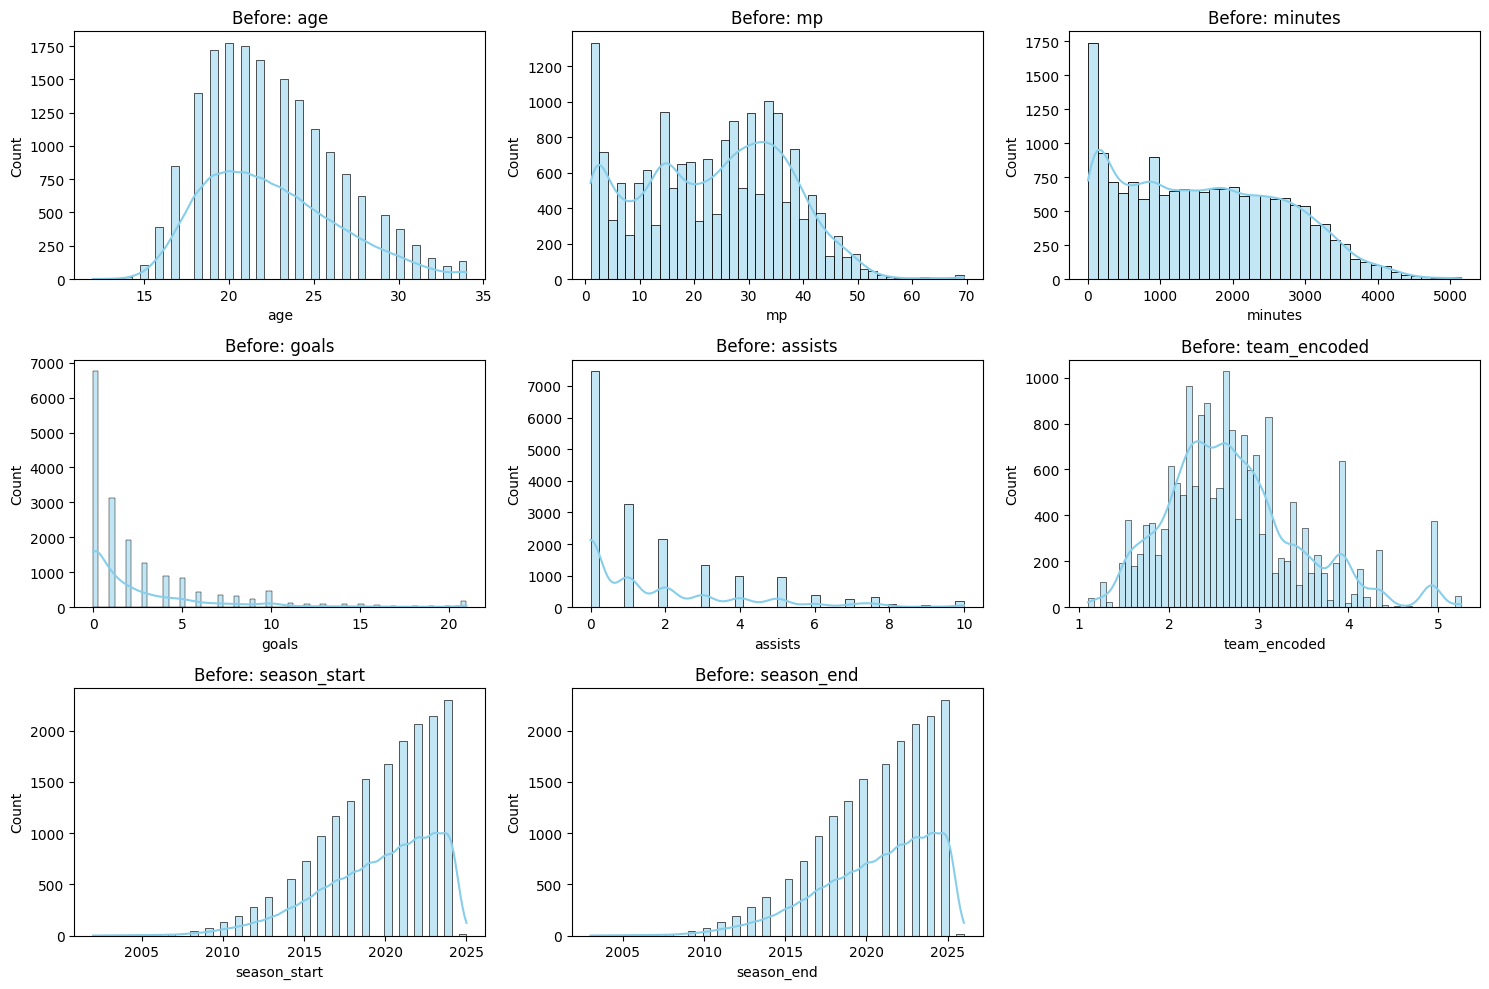

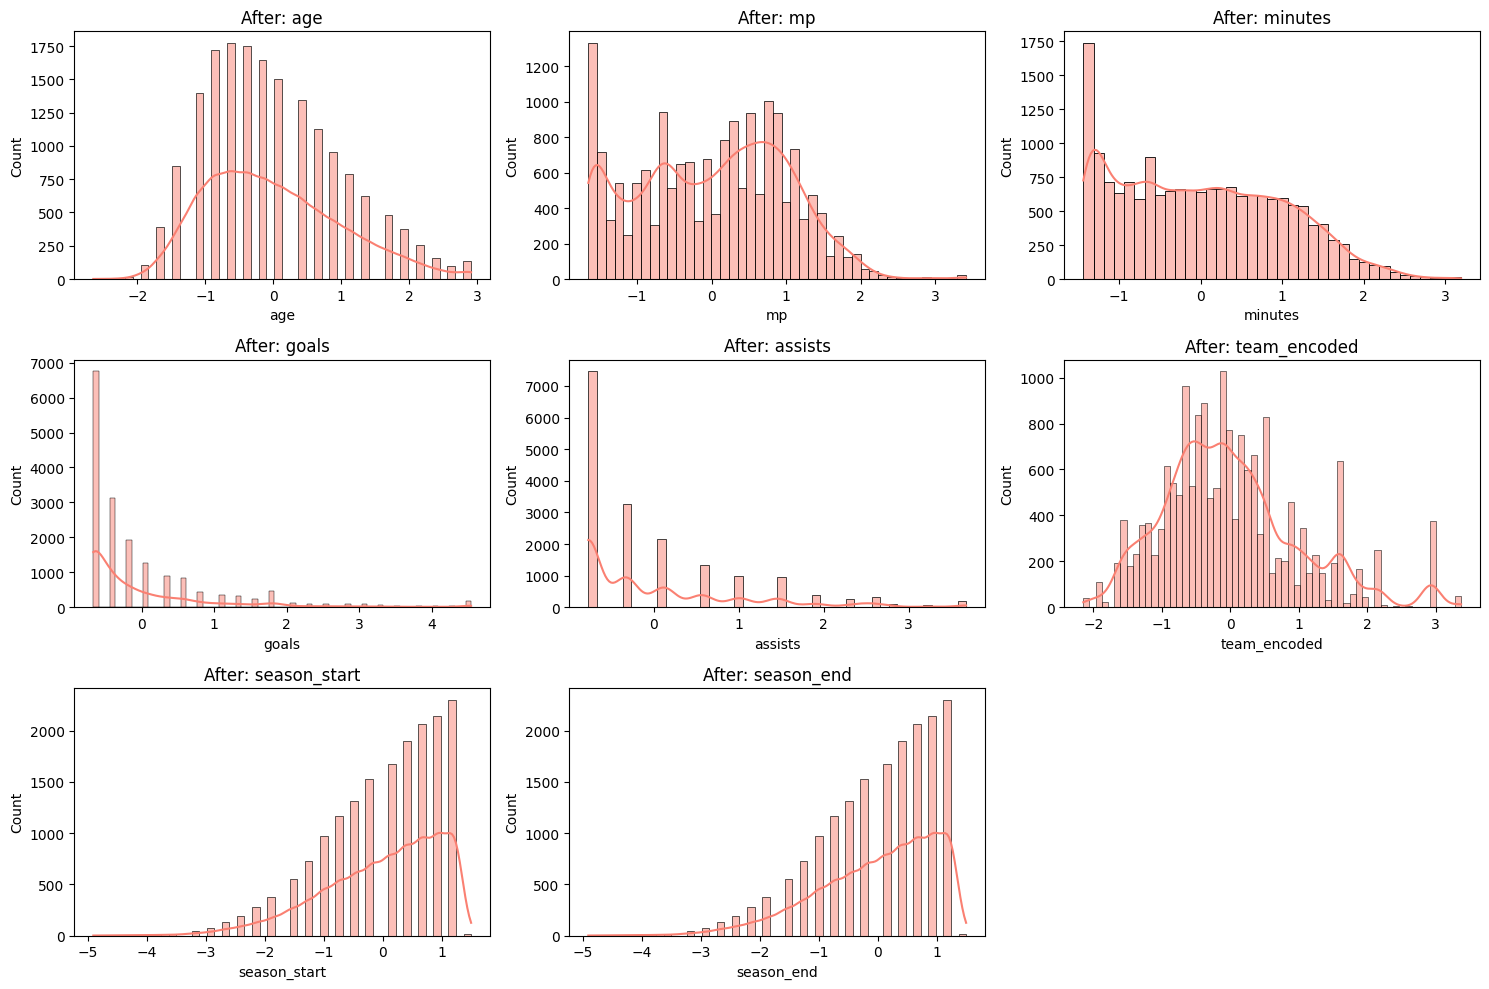


Standardized DataFrame Description:
                age            mp       minutes         goals       assists  \
count  1.749700e+04  1.749700e+04  1.749700e+04  1.749700e+04  1.749700e+04   
mean   3.472104e-16 -1.380720e-17  5.441660e-17  2.253822e-17 -1.137063e-17   
std    1.000029e+00  1.000029e+00  1.000029e+00  1.000029e+00  1.000029e+00   
min   -2.649150e+00 -1.657880e+00 -1.439155e+00 -6.664194e-01 -7.710299e-01   
25%   -8.804845e-01 -7.686949e-01 -8.854285e-01 -6.664194e-01 -7.710299e-01   
50%   -1.224849e-01  4.639167e-02 -7.012065e-02 -4.185696e-01 -3.263203e-01   
75%    6.355147e-01  7.873794e-01  7.838402e-01  3.249797e-01  5.630989e-01   
max    2.909514e+00  3.417886e+00  3.194707e+00  4.538426e+00  3.676066e+00   

       team_encoded  season_start    season_end  
count  1.749700e+04  1.749700e+04  1.749700e+04  
mean   1.102545e-16  1.912033e-14  1.912033e-14  
std    1.000029e+00  1.000029e+00  1.000029e+00  
min   -2.146455e+00 -4.907752e+00 -4.907752e+00  
2

In [14]:
# Select numerical columns to standardize (excluding one-hot encoded and label encoded columns)
numeric_cols = ['age', 'mp', 'minutes', 'goals', 'assists', 'team_encoded', 'season_start', 'season_end']
# You might want to exclude some columns if they are already normalized (like one-hot encoded positions)

# Before Standardization - Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Before: {col}')
plt.tight_layout()
plt.show()

# Standardize the features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# After Standardization - Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_scaled[col], kde=True, color='salmon')
    plt.title(f'After: {col}')
plt.tight_layout()
plt.show()

# Display the standardized DataFrame stats
print("\nStandardized DataFrame Description:")
print(df_scaled[numeric_cols].describe())

In [15]:
# Feature Engineering - Revised with Error Handling

# First, let's verify what columns we actually have
print("Current columns in df:", df.columns.tolist())

# 1. Ensure we have the basic stats columns we need
required_stats = ['goals', 'assists', 'minutes', 'mp']
for col in required_stats:
    if col not in df.columns:
        print(f"Error: Missing required column {col}")
        # Handle missing columns - you might need to go back to preprocessing

# 2. Create rate metrics safely
if 'minutes' in df.columns:
    # Replace 0 minutes to avoid division by zero
    df['minutes_adj'] = df['minutes'].replace(0, 1)
    
    # Create per-90 metrics only if we have the required columns
    if 'goals' in df.columns:
        df['goals_per_90'] = (df['goals'] * 90) / df['minutes_adj']
    else:
        print("Warning: 'goals' column missing - skipping goals_per_90")
    
    if 'assists' in df.columns:
        df['assists_per_90'] = (df['assists'] * 90) / df['minutes_adj']
    else:
        print("Warning: 'assists' column missing - skipping assists_per_90")
else:
    print("Error: 'minutes' column missing - cannot create per-90 metrics")

# 3. Verify position columns exist or create them
position_cols = ['pos_DF', 'pos_MF', 'pos_FW']
if not all(col in df.columns for col in position_cols):
    print("Creating position dummy columns...")
    if 'position' in df.columns:
        position_dummies = pd.get_dummies(df['position'], prefix='pos')
        df = pd.concat([df, position_dummies], axis=1)
    else:
        print("Error: Neither position dummies nor 'position' column exists")
        # You may need to add logic to infer positions from the data

# 4. Create position score only if we have the required metrics
if all(col in df.columns for col in ['goals_per_90', 'assists_per_90'] + position_cols):
    conditions = [
        df['pos_FW'] == 1,
        df['pos_MF'] == 1,
        df['pos_DF'] == 1
    ]
    choices = [
        0.7 * df['goals_per_90'] + 0.3 * df['assists_per_90'],  # Forwards
        0.4 * df['goals_per_90'] + 0.6 * df['assists_per_90'],  # Midfielders
        0.2 * df['goals_per_90'] + 0.3 * df['assists_per_90'] + 
        0.5 * (df['minutes'] / df['minutes'].max())  # Defenders
    ]
    df['position_score'] = np.select(conditions, choices, default=0)
else:
    print("Warning: Missing required columns for position_score")

# 5. Now safely create the weighted recent features
def weighted_recent(series):
    if len(series) > 1:
        weights = np.arange(1, len(series)+1)
        return np.average(series, weights=weights)
    return series.iloc[0]

# Only try to create weighted features for columns that exist
stats_to_weight = []
if 'goals_per_90' in df.columns:
    stats_to_weight.append('goals_per_90')
if 'assists_per_90' in df.columns:
    stats_to_weight.append('assists_per_90')
if 'position_score' in df.columns:
    stats_to_weight.append('position_score')

for stat in stats_to_weight:
    df[f'{stat}_weighted_recent'] = df.groupby('player_id')[stat].transform(weighted_recent)

# 6. Continue with other features only if we have the required columns
if all(col in df.columns for col in ['minutes', 'mp']):
    df['mins_per_appearance'] = df['minutes'] / df['mp'].replace(0, 1)
    df['availability'] = df['mp'] / df.groupby('player_id')['mp'].transform('max')
else:
    print("Warning: Missing columns for durability features")

# Print the new columns we've created
new_features = [col for col in df.columns if col not in required_stats + position_cols]
print("\nSuccessfully created features:", new_features)

Current columns in df: ['age', 'mp', 'minutes', 'goals', 'assists', 'pos_DF', 'pos_FW', 'pos_MF', 'team_encoded', 'season_start', 'season_end', 'player_id']

Successfully created features: ['age', 'team_encoded', 'season_start', 'season_end', 'player_id', 'minutes_adj', 'goals_per_90', 'assists_per_90', 'position_score', 'goals_per_90_weighted_recent', 'assists_per_90_weighted_recent', 'position_score_weighted_recent', 'mins_per_appearance', 'availability']


In [16]:
df_scaled.shape

(17497, 12)


Class distribution for longevity prediction:
has_next_season
1.0    15097
0.0      257
Name: count, dtype: int64
Training Random Forest...
Training XGBoost...
Training Gradient Boosting...
Training Linear Regression...
Training SVR...
Training Neural Network...

=== Performance Prediction Results ===

All Performance Metrics:
     Value             Model    Metric Type  Target          Metric
108.091214     Random Forest     Regression     NaN             NaN
 36.959901     Random Forest     Regression     NaN             NaN
  0.833982     Random Forest     Regression     NaN             NaN
  0.868121     Random Forest Classification   goals        Accuracy
  0.868447     Random Forest Classification   goals Weighted Avg F1
  0.863562     Random Forest Classification assists        Accuracy
  0.863083     Random Forest Classification assists Weighted Avg F1
  0.880821     Random Forest Classification      mp        Accuracy
  0.880975     Random Forest Classification      mp Weighte

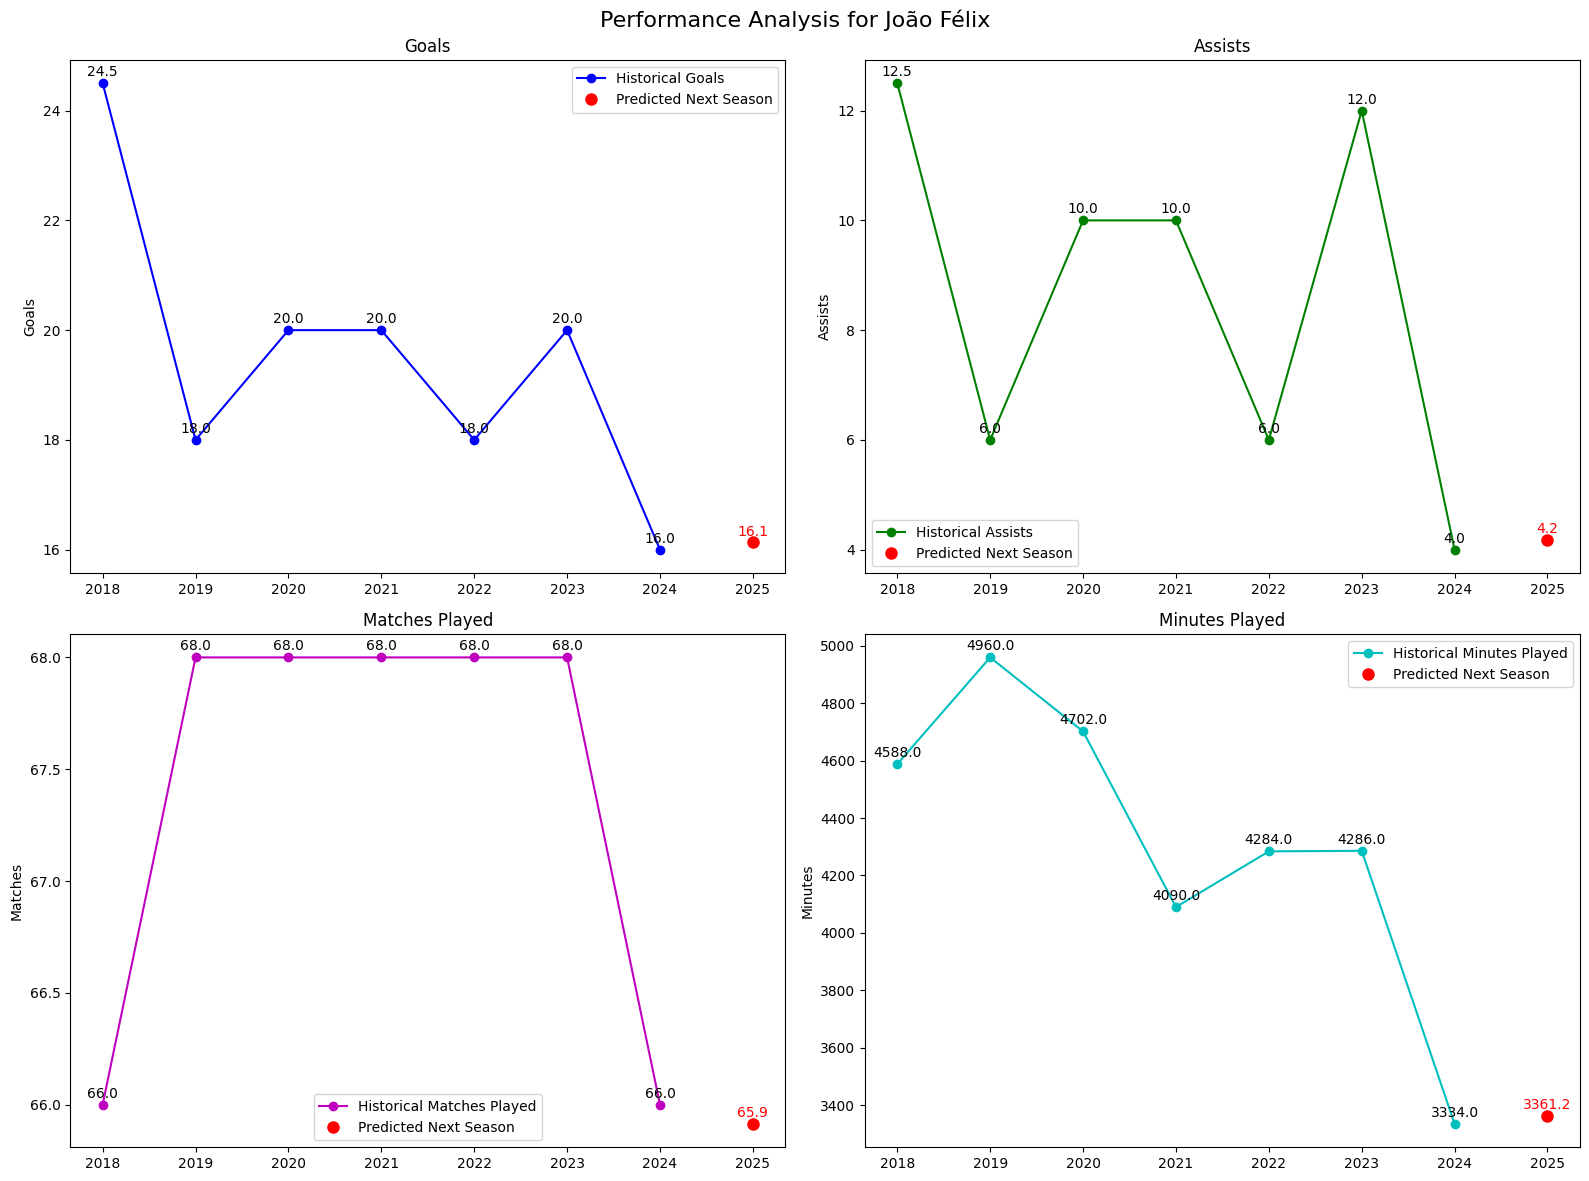


Performance Table:
 Season     Goals   Assists  Matches     Minutes       Type
   2018 24.500000 12.500000 66.00000 4588.000000 Historical
   2019 18.000000  6.000000 68.00000 4960.000000 Historical
   2020 20.000000 10.000000 68.00000 4702.000000 Historical
   2021 20.000000 10.000000 68.00000 4090.000000 Historical
   2022 18.000000  6.000000 68.00000 4284.000000 Historical
   2023 20.000000 12.000000 68.00000 4286.000000 Historical
   2024 16.000000  4.000000 66.00000 3334.000000 Historical
   2025 16.131407  4.178195 65.91349 3361.234131  Predicted

Performance Context for João Félix (FW):
Metric               Predicted   Position Avg
Goals                     16.1            7.1
Assists                    4.2            3.1
Matches                   65.9           28.9
Minutes                 3361.2         1774.8

Mins/Match                51.0           61.3

Class distribution for longevity prediction:
has_next_season
1.0    15097
0.0      257
Name: count, dtype: int64

Probab

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

# Load and preprocess data
def load_and_preprocess(filepath):
    # Load data with proper parsing
    df = pd.read_csv(filepath, thousands=',', quotechar='"')
    
    # Clean position data
    df['position'] = df['position'].str.upper().str.strip()
    valid_positions = ['DF', 'MF', 'FW']
    df['position'] = df['position'].apply(lambda x: x if x in valid_positions else np.nan)
    
    # Convert numeric columns
    numeric_cols = ['minutes', 'goals', 'assists', 'mp']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # For players with multiple teams in a season, we want to sum their stats
    # but keep their primary position (most common position)
    def get_primary_position(positions):
        return positions.mode()[0] if not positions.mode().empty else np.nan
    
    df = df.groupby(['player_name', 'season']).agg({
        'position': get_primary_position,
        'age': 'mean',
        'mp': 'sum',
        'minutes': 'sum',
        'goals': 'sum',
        'assists': 'sum',
        'team': lambda x: ', '.join(x.unique())  # Only join unique teams
    }).reset_index()
    
    # Calculate per-90 metrics
    df['minutes_adj'] = df['minutes'].replace(0, 1)
    df['goals_per_90'] = (df['goals'] * 90) / df['minutes_adj']
    df['assists_per_90'] = (df['assists'] * 90) / df['minutes_adj']
    
    # Extract season start year
    df['season_start'] = df['season'].str.split('-').str[0].astype(int)
    
    return df

def prepare_player_history(player_name, df):
    """Prepare accurate historical data for plotting"""
    player_data = df[df['player_name'] == player_name].sort_values('season_start')
    
    # Create clean historical records with consistent column names
    history = player_data[[
        'season_start', 'position', 'goals', 'assists', 'mp', 'minutes',
        'goals_per_90', 'assists_per_90'
    ]].copy()
    
    # Rename columns to match what plotting functions expect
    history = history.rename(columns={
        'season_start': 'Season',
        'goals': 'Goals',
        'assists': 'Assists',
        'mp': 'Matches',
        'minutes': 'Minutes',
        'goals_per_90': 'Goals per 90',
        'assists_per_90': 'Assists per 90'
    })
    
    return history

# Feature engineering
def feature_engineering(df):
    # Position encoding
    position_dummies = pd.get_dummies(df['position'], prefix='pos')
    df = pd.concat([df, position_dummies], axis=1)
    
    # Team encoding (target encoding using goals)
    team_encoder = TargetEncoder()
    df['team_encoded'] = team_encoder.fit_transform(df['team'], df['goals'])
    
    # Season processing
    df = df.dropna(subset=['season'])
    df['season'] = df['season'].apply(lambda x: f"{x}-{int(x)+1}" if len(x) == 4 else x)
    valid_season_format = df['season'].str.contains(r'^\d{4}-\d{4}$', na=False)
    df = df[valid_season_format]
    df['season_start'] = df['season'].str.split('-').str[0].astype(int)
    df['season_end'] = df['season'].str.split('-').str[1].astype(int)
    
    # Player ID encoding
    le = LabelEncoder()
    df['player_id'] = le.fit_transform(df['player_name'])
    
    # Rate metrics
    df['minutes_adj'] = df['minutes'].replace(0, 1)
    df['goals_per_90'] = (df['goals'] * 90) / df['minutes_adj']
    df['assists_per_90'] = (df['assists'] * 90) / df['minutes_adj']
    
    # Position score
    conditions = [
        df['pos_FW'] == 1,
        df['pos_MF'] == 1,
        df['pos_DF'] == 1
    ]
    choices = [
        0.7 * df['goals_per_90'] + 0.3 * df['assists_per_90'],  # Forwards
        0.4 * df['goals_per_90'] + 0.6 * df['assists_per_90'],  # Midfielders
        0.2 * df['goals_per_90'] + 0.3 * df['assists_per_90'] + 0.5 * (df['minutes'] / df['minutes'].max())  # Defenders
    ]
    df['position_score'] = np.select(conditions, choices, default=0)
    
    # Weighted recent features
    def weighted_recent(series):
        if len(series) > 1:
            weights = np.arange(1, len(series)+1)
            return np.average(series, weights=weights)
        return series.iloc[0]
    
    for stat in ['goals_per_90', 'assists_per_90', 'position_score', 'minutes']:
        df[f'{stat}_weighted_recent'] = df.groupby('player_id')[stat].transform(weighted_recent)
    
    # Durability features
    df['mins_per_appearance'] = df['minutes'] / df['mp'].replace(0, 1)
    df['availability'] = df['mp'] / df.groupby('player_id')['mp'].transform('max')
    
    # Career stage features
    df['career_stage'] = pd.cut(df['age'], 
                                bins=[0, 21, 25, 29, 35, 100],
                                labels=['emerging', 'developing', 'prime', 'experienced', 'veteran'])
    
    # Time since debut
    df['debut_season'] = df.groupby('player_id')['season_start'].transform('min')
    df['seasons_since_debut'] = df['season_start'] - df['debut_season']
    
    # Recent form (last 3 seasons)
    df['recent_form'] = df.groupby('player_id')['position_score'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    # Team strength metric
    df['team_strength'] = df.groupby(['team', 'season_start'])['position_score'].transform('mean')
    
    # Injury proneness indicator (more sophisticated version)
    df['injury_prone'] = (df['minutes'] / (df['mp'] * 90).replace(0, 1)) < 0.6  # Playing <60% of possible minutes
    
    # Minutes-specific features
    df['mins_pct_possible'] = df['minutes'] / (df['mp'] * 90).replace(0, 1)  # Percentage of possible minutes
    df['rolling_3season_mins'] = df.groupby('player_id')['minutes'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['rolling_3season_mins_pct'] = df.groupby('player_id')['mins_pct_possible'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    return df

# Outlier handling
def handle_outliers(df):
    # Age outliers
    Q1 = df['age'].quantile(0.25)
    Q3 = df['age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df['age'] = np.clip(df['age'], lower_bound, upper_bound)
    
    # Stats outliers by position
    stats_cols = ['mp', 'goals', 'assists', 'minutes', 'goals_per_90', 'assists_per_90']
    for col in stats_cols:
        df[col] = df.groupby('position')[col].transform(
            lambda x: np.clip(
                x,
                x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)),
                x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))
            )
        )
    
    return df

def prepare_data(df, target_player=None, test_size=0.2, random_state=42):
    # Ensure 'season_start' exists
    if 'season_start' not in df.columns:
        raise KeyError("The 'season_start' column is missing from the DataFrame.")
    
    # Sort by player and season
    df = df.sort_values(['player_id', 'season_start'])
    
    # Create proper 'has_next_season' column
    # First, identify all player-season combinations that exist
    player_seasons = df[['player_id', 'season_start']].drop_duplicates()
    
    # For each player, mark seasons where they didn't appear next season
    df['has_next_season'] = 1  # Initialize to 1 (plays next season)
    
    # Group by player and check consecutive seasons
    for player_id, group in df.groupby('player_id'):
        seasons = sorted(group['season_start'].unique())
        for i in range(len(seasons)-1):
            current_season = seasons[i]
            next_season = seasons[i+1]
            if next_season != current_season + 1:
                # Player didn't play next season
                df.loc[(df['player_id']==player_id) & 
                      (df['season_start']==current_season), 'has_next_season'] = 0
    
    # For the most recent season, we don't know if they'll play next season
    max_season = df['season_start'].max()
    df.loc[df['season_start'] == max_season, 'has_next_season'] = np.nan
    
    # Drop rows where we don't know about next season
    df = df.dropna(subset=['has_next_season'])
    
    # Check class balance
    class_counts = df['has_next_season'].value_counts()
    print("\nClass distribution for longevity prediction:")
    print(class_counts)
    
    # If predicting for a specific player
    if target_player:
        player_data = df[df['player_name'] == target_player]
        other_data = df[df['player_name'] != target_player]
        
        # Use all data for training except the most recent season for the target player
        if len(player_data) > 1:
            train_data = pd.concat([other_data, player_data.iloc[:-1]])
            test_data = player_data.iloc[-1:]
        else:
            train_data = other_data
            test_data = player_data
    else:
        # For general modeling, ensure we maintain class balance in the split
        X_train, X_test, y_train, y_test = train_test_split(
            df.drop('has_next_season', axis=1),
            df['has_next_season'],
            test_size=test_size,
            random_state=random_state,
            stratify=df['has_next_season']
        )
        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)
    
    # Features and targets for performance prediction
    feature_cols = [
        'age', 'pos_DF', 'pos_MF', 'pos_FW', 'team_encoded', 'season_start',
        'goals_per_90', 'assists_per_90', 'position_score',
        'goals_per_90_weighted_recent', 'assists_per_90_weighted_recent',
        'position_score_weighted_recent', 'mins_per_appearance', 'availability',
        'seasons_since_debut', 'recent_form', 'team_strength', 'injury_prone',
        'mins_pct_possible', 'rolling_3season_mins', 'rolling_3season_mins_pct',
        'minutes_weighted_recent'
    ]
    target_cols = ['goals', 'assists', 'mp', 'minutes']
    
    # Add imputation for missing values
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(train_data[feature_cols])
    X_test = imputer.transform(test_data[feature_cols])
    y_train = train_data[target_cols].values
    y_test = test_data[target_cols].values
    
    # Features and targets for career longevity prediction
    X_train_longevity = train_data[feature_cols]
    y_train_longevity = train_data['has_next_season']
    X_test_longevity = test_data[feature_cols]
    y_test_longevity = test_data['has_next_season']
    
    return {
        'performance': (X_train, y_train, X_test, y_test),
        'longevity': (X_train_longevity, y_train_longevity, X_test_longevity, y_test_longevity),
        'player_data': test_data if target_player else None,
        'feature_names': feature_cols
    }

def train_performance_models(X_train, y_train):
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
        'Linear Regression': MultiOutputRegressor(LinearRegression()),
        'SVR': MultiOutputRegressor(SVR()),
        'Neural Network': MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=500))
    }

    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model

    return trained_models

def train_longevity_model(X_train, y_train):
    # Check class distribution
    class_counts = Counter(y_train)
    print("\nClass distribution before balancing:")
    print(class_counts)
    
    if len(class_counts) < 2:
        print(f"Warning: Only one class present in training data: {class_counts}")
        return None
    
    # First impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_res, y_res = smote.fit_resample(X_train_imputed, y_train)
    
    print("\nClass distribution after balancing:")
    print(Counter(y_res))
    
    # Train the model with balanced data
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_res, y_res)
    return model, imputer  # Return both model and imputer for later use

def evaluate_models(models, X_test, y_test, task='performance'):
    results = {}

    if task == 'performance':
        for name, model in models.items():
            y_pred = model.predict(X_test)

            # Regression metrics
            regression_metrics = {
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)
            }

            # Classification metrics (after binning)
            classification_reports = {}
            target_names = ['goals', 'assists', 'mp', 'minutes']

            for i, target in enumerate(target_names):
                try:
                    binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
                    y_true_binned = binner.fit_transform(y_test[:, i].reshape(-1, 1)).flatten().astype(int)
                    y_pred_binned = binner.transform(y_pred[:, i].reshape(-1, 1)).flatten().astype(int)

                    # Dynamically adjust target names based on the number of unique bins
                    unique_classes = np.unique(y_true_binned)
                    dynamic_target_names = [f"Class {cls}" for cls in unique_classes]

                    report = classification_report(
                        y_true_binned,
                        y_pred_binned,
                        target_names=dynamic_target_names,
                        output_dict=True
                    )
                    classification_reports[target] = {
                        'Accuracy': report['accuracy'],
                        'Weighted Avg F1': report['weighted avg']['f1-score']
                    }
                except ValueError as e:
                    print(f"Skipping classification metrics for {target} due to error: {e}")
                    classification_reports[target] = {}

            results[name] = {
                'Regression': regression_metrics,
                'Classification': classification_reports
            }
    else:  # longevity
        if models is None:
            print("No longevity model was trained due to insufficient class diversity.")
            return results

        y_pred = models.predict(X_test)
        y_pred_proba = models.predict_proba(X_test)[:, 1]
        results = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba),
            'Class Distribution': dict(Counter(y_test))
        }

    return results

def analyze_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        if len(importances.shape) > 1:  # For multi-output models
            importances = np.mean(importances, axis=0)
    else:
        return None
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return importance_df

def interpret_prediction(player_name, pred_goals, pred_assists, pred_matches, pred_minutes, df):
    player_pos = df[df['player_name']==player_name]['position'].mode()[0]
    pos_avg = df[df['position']==player_pos][['goals', 'assists', 'mp', 'minutes']].mean()
    
    print(f"\nPerformance Context for {player_name} ({player_pos}):")
    print(f"{'Metric':<15}{'Predicted':>15}{'Position Avg':>15}")
    print(f"{'Goals':<15}{pred_goals[0]:>15.1f}{pos_avg[0]:>15.1f}")
    print(f"{'Assists':<15}{pred_assists[0]:>15.1f}{pos_avg[1]:>15.1f}")
    print(f"{'Matches':<15}{pred_matches[0]:>15.1f}{pos_avg[2]:>15.1f}")
    print(f"{'Minutes':<15}{pred_minutes[0]:>15.1f}{pos_avg[3]:>15.1f}")
    
    # Calculate predicted minutes per match
    pred_mins_per_match = pred_minutes[0] / pred_matches[0] if pred_matches[0] > 0 else 0
    pos_avg_mins_per_match = pos_avg[3] / pos_avg[2] if pos_avg[2] > 0 else 0
    print(f"\n{'Mins/Match':<15}{pred_mins_per_match:>15.1f}{pos_avg_mins_per_match:>15.1f}")

def plot_player_performance(player_name, player_history, pred_goals, pred_assists, pred_matches, pred_minutes):
    """Plot historical performance and predictions for a player with actual historical data"""
    # Ensure we have the required columns
    required_columns = ['Season', 'Goals', 'Assists', 'Matches', 'Minutes']
    for col in required_columns:
        if col not in player_history.columns:
            raise ValueError(f"Required column '{col}' not found in player history data")
    
    # Ensure numeric types for plotting
    player_history = player_history.infer_objects()
    
    # Create figure with 4 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Performance Analysis for {player_name}', fontsize=16)
    
    # Goals plot
    ax1.plot(player_history['Season'], player_history['Goals'], 
             'bo-', label='Historical Goals')
    ax1.plot(player_history['Season'].max()+1, pred_goals[0], 
             'ro', markersize=8, label='Predicted Next Season')
    ax1.set_title('Goals')
    ax1.set_ylabel('Goals')
    ax1.legend()
    
    # Add data labels for goals
    for x, y in zip(player_history['Season'], player_history['Goals']):
        ax1.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,5), ha='center')
    ax1.annotate(f"{pred_goals[0]:.1f}", 
                (player_history['Season'].max()+1, pred_goals[0]), 
                textcoords="offset points", xytext=(0,5), ha='center', color='red')
    
    # Assists plot
    ax2.plot(player_history['Season'], player_history['Assists'], 
             'go-', label='Historical Assists')
    ax2.plot(player_history['Season'].max()+1, pred_assists[0], 
             'ro', markersize=8, label='Predicted Next Season')
    ax2.set_title('Assists')
    ax2.set_ylabel('Assists')
    ax2.legend()
    
    # Add data labels for assists
    for x, y in zip(player_history['Season'], player_history['Assists']):
        ax2.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,5), ha='center')
    ax2.annotate(f"{pred_assists[0]:.1f}", 
                (player_history['Season'].max()+1, pred_assists[0]), 
                textcoords="offset points", xytext=(0,5), ha='center', color='red')
    
    # Matches plot
    ax3.plot(player_history['Season'], player_history['Matches'], 
             'mo-', label='Historical Matches Played')
    ax3.plot(player_history['Season'].max()+1, pred_matches[0], 
             'ro', markersize=8, label='Predicted Next Season')
    ax3.set_title('Matches Played')
    ax3.set_ylabel('Matches')
    ax3.legend()
    
    # Add data labels for matches
    for x, y in zip(player_history['Season'], player_history['Matches']):
        ax3.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,5), ha='center')
    ax3.annotate(f"{pred_matches[0]:.1f}", 
                (player_history['Season'].max()+1, pred_matches[0]), 
                textcoords="offset points", xytext=(0,5), ha='center', color='red')
    
    # Minutes plot
    ax4.plot(player_history['Season'], player_history['Minutes'], 
             'co-', label='Historical Minutes Played')
    ax4.plot(player_history['Season'].max()+1, pred_minutes[0], 
             'ro', markersize=8, label='Predicted Next Season')
    ax4.set_title('Minutes Played')
    ax4.set_ylabel('Minutes')
    ax4.legend()
    
    # Add data labels for minutes
    for x, y in zip(player_history['Season'], player_history['Minutes']):
        ax4.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,5), ha='center')
    ax4.annotate(f"{pred_minutes[0]:.1f}", 
                (player_history['Season'].max()+1, pred_minutes[0]), 
                textcoords="offset points", xytext=(0,5), ha='center', color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Prepare and return the table data
    history_table = player_history[['Season', 'Goals', 'Assists', 'Matches', 'Minutes']].copy()
    history_table['Type'] = 'Historical'
    
    pred_row = pd.DataFrame({
        'Season': [player_history['Season'].max()+1],
        'Goals': [pred_goals[0]],
        'Assists': [pred_assists[0]],
        'Matches': [pred_matches[0]],
        'Minutes': [pred_minutes[0]],
        'Type': ['Predicted']
    })
    table_data = pd.concat([history_table, pred_row])
    
    return table_data

def print_evaluation_results(perf_results, longevity_results):
    """Print all evaluation results in copyable format"""
    
    print("\n=== Performance Prediction Results ===")
    all_perf_results = []
    for model_name, metrics in perf_results.items():
        # Regression metrics
        reg_df = pd.DataFrame(metrics['Regression'], index=['Value']).T
        reg_df['Model'] = model_name
        reg_df['Metric Type'] = 'Regression'
        
        # Classification metrics
        classif_df = pd.DataFrame(metrics['Classification']).T.stack().reset_index()
        classif_df.columns = ['Target', 'Metric', 'Value']
        classif_df['Model'] = model_name
        classif_df['Metric Type'] = 'Classification'
        
        all_perf_results.append(reg_df)
        all_perf_results.append(classif_df)

    # Combine all results
    combined_perf_results = pd.concat(all_perf_results)
    print("\nAll Performance Metrics:")
    print(combined_perf_results.to_string(index=False))
    
    # Career longevity results
    if longevity_results:
        print("\nCareer Longevity Prediction Results:")
        print(pd.Series(longevity_results).to_string())

def get_playing_probability(player_name, df, model, imputer):
    """Get the probability that a player will play next season"""
    # Prepare the player's data
    player_data = prepare_data(df, target_player=player_name)
    
    # Get the features for longevity prediction
    X_player = player_data['longevity'][2]  # This is the test data for our target player
    
    # Impute missing values and predict probability
    if model and imputer:
        X_player_imputed = imputer.transform(X_player)
        prob_playing = model.predict_proba(X_player_imputed)[0][1]  # Probability of class 1 (will play)
        return prob_playing
    else:
        return None
            
def main():
    # Load and preprocess data
    df = load_and_preprocess('player_stats_with_positions.csv')
    
    # Feature engineering
    df = feature_engineering(df)
    
    # Handle outliers
    df = handle_outliers(df)
    
    # Prepare data for modeling
    data = prepare_data(df)
    
    # Performance prediction
    X_train_perf, y_train_perf, X_test_perf, y_test_perf = data['performance']
    performance_models = train_performance_models(X_train_perf, y_train_perf)
    perf_results = evaluate_models(performance_models, X_test_perf, y_test_perf)
    
    # Print performance results
    print("\n=== Performance Prediction Results ===")
    all_perf_results = []
    for model_name, metrics in perf_results.items():
        reg_df = pd.DataFrame(metrics['Regression'], index=['Value']).T
        reg_df['Model'] = model_name
        reg_df['Metric Type'] = 'Regression'
        
        classif_df = pd.DataFrame(metrics['Classification']).T.stack().reset_index()
        classif_df.columns = ['Target', 'Metric', 'Value']
        classif_df['Model'] = model_name
        classif_df['Metric Type'] = 'Classification'
        
        all_perf_results.append(reg_df)
        all_perf_results.append(classif_df)

    combined_perf_results = pd.concat(all_perf_results)
    print("\nAll Performance Metrics:")
    print(combined_perf_results.to_string(index=False))
    
    # Career longevity prediction
    X_train_long, y_train_long, X_test_long, y_test_long = data['longevity']
    longevity_model, imputer = train_longevity_model(X_train_long, y_train_long)
    
    longevity_results = None
    if longevity_model:
        # Impute test data before evaluation
        X_test_long_imputed = imputer.transform(X_test_long)
        longevity_results = evaluate_models(longevity_model, X_test_long_imputed, y_test_long, task='longevity')
        print("\nCareer Longevity Prediction Results:")
        print(pd.Series(longevity_results).to_string())
    
    # Feature importance
    best_perf_model = performance_models['XGBoost']
    feature_importance = analyze_feature_importance(best_perf_model, data['feature_names'])
    
    print("\nFeature Importance for Performance Prediction:")
    print(feature_importance.head(10).to_string(index=False))
    
    if longevity_model:
        longevity_importance = analyze_feature_importance(longevity_model, data['feature_names'])
        print("\nFeature Importance for Career Longevity Prediction:")
        print(longevity_importance.head(10).to_string(index=False))
    
    # Example prediction for 
    target_player = "João Félix"
    if target_player in df['player_name'].unique():
        # Get accurate historical data
        player_history = prepare_player_history(target_player, df)
        print("\nVerified Historical Data:")
        print(player_history.to_string(index=False))
        
        # Prepare prediction data
        player_data = prepare_data(df, target_player=target_player)
        
        # Performance prediction
        next_season_pred = best_perf_model.predict(player_data['performance'][2])
        print(f"\nPredicted performance for {target_player} next season:")
        print(f"Goals: {next_season_pred[0][0]:.1f}, Assists: {next_season_pred[0][1]:.1f}, Matches: {next_season_pred[0][2]:.1f}, Minutes: {next_season_pred[0][3]:.1f}")
        
        # Plot with verified data
        performance_table = plot_player_performance(
            target_player,
            player_history,
            [next_season_pred[0][0]],
            [next_season_pred[0][1]],
            [next_season_pred[0][2]],
            [next_season_pred[0][3]]
        )
        
        print("\nPerformance Table:")
        print(performance_table.to_string(index=False))
        
        # Interpretation with minutes
        interpret_prediction(
            target_player,
            [next_season_pred[0][0]],
            [next_season_pred[0][1]],
            [next_season_pred[0][2]],
            [next_season_pred[0][3]],
            df
        )
        
        # Career longevity prediction
        if longevity_model:
            longevity_prob = get_playing_probability(target_player, df, longevity_model, imputer)
            print(f"\nProbability {target_player} will play next season: {longevity_prob*100:.1f}%")
        
if __name__ == "__main__":
    main()